In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/nassim/dev/reinforcement-learning


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import itertools
from collections import defaultdict
from lib.envs.maze import MazeEnv
from lib import plotting

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
%matplotlib inline

In [3]:
env = MazeEnv()

# Environment

In [4]:
env.reset()
env.render()
print(env.step(0))
env.render()
print(env.step(1))
env.render()
print(env.step(1))
env.render()
print(env.step(2))
env.render()
print(env.step(3))
env.render()

.  .  .  .  .  .  .  |  G
.  .  |  .  .  .  .  |  .
x  .  |  .  .  .  .  |  .
.  .  |  .  .  .  .  .  .
.  .  .  .  .  |  .  .  .
.  .  .  .  .  .  .  .  .
(9, 0.0, False, {'prob': 1.0})
.  .  .  .  .  .  .  |  G
x  .  |  .  .  .  .  |  .
S  .  |  .  .  .  .  |  .
.  .  |  .  .  .  .  .  .
.  .  .  .  .  |  .  .  .
.  .  .  .  .  .  .  .  .
(10, 0.0, False, {'prob': 1.0})
.  .  .  .  .  .  .  |  G
.  x  |  .  .  .  .  |  .
S  .  |  .  .  .  .  |  .
.  .  |  .  .  .  .  .  .
.  .  .  .  .  |  .  .  .
.  .  .  .  .  .  .  .  .
(10, 0.0, False, {'prob': 1.0})
.  .  .  .  .  .  .  |  G
.  x  |  .  .  .  .  |  .
S  .  |  .  .  .  .  |  .
.  .  |  .  .  .  .  .  .
.  .  .  .  .  |  .  .  .
.  .  .  .  .  .  .  .  .
(19, 0.0, False, {'prob': 1.0})
.  .  .  .  .  .  .  |  G
.  .  |  .  .  .  .  |  .
S  x  |  .  .  .  .  |  .
.  .  |  .  .  .  .  .  .
.  .  .  .  .  |  .  .  .
.  .  .  .  .  .  .  .  .
(18, 0.0, False, {'prob': 1.0})
.  .  .  .  .  .  .  |  G
.  .  |  .  .  .  .  |  .
x  .  |  

# Dyna-Q

In [5]:
n_episodes = 200

In [6]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # If there's no best action yet, let it be selected randomly
        if len(set(Q[observation])) == 1:
            A = np.ones(nA, dtype=float) / nA
        else: 
            A = np.ones(nA, dtype=float) * epsilon / nA
            best_action = np.argmax(Q[observation])
            A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def dyna_q(env, num_episodes, num_planning, discount_factor=0.95, alpha=0.1, epsilon=0.1):
    """
    Dyna-Q algorithm: Planning+Learning
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        num_planning: Number of simulated experience runs.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The model used for planning
    model = defaultdict(dict)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        state = env.reset()

        for step in itertools.count():

            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # TD update
            best_next_action = np.argmax(Q[next_state]) 
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

            # Update model
            # Assumes deterministic environment
            model[state][action] = (next_state, reward)

            # Update Q-values on simulated experience
            for _ in range(num_planning):
                _state = np.random.choice(list(model.keys()))
                _action = np.random.choice(list(model[_state].keys()))

                _next_state, _reward, = model[_state][_action]

                # TD update
                _best_next_action = np.argmax(Q[_next_state]) 
                td_target = _reward + discount_factor * Q[_next_state][_best_next_action]
                td_error = td_target - Q[_state][_action]
                Q[_state][_action] += alpha * td_error

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = step

            if done:
                break
    
    return Q, stats

In [8]:
print("Q-Learning training")
Q1, stats_q = dyna_q(env, n_episodes, 0)
print("\nDyna-Q w/ n=10 training")
Q2, stats_dq = dyna_q(env, n_episodes, 10)
print("\nDyna-Q w/ n=50 training")
Q3, stats_dq2 = dyna_q(env, n_episodes, 50) 

Q-Learning training
Episode 200/200.
Dyna-Q w/ n=10 training
Episode 200/200.
Dyna-Q w/ n=50 training
Episode 200/200.

# Performance comparison

In [9]:
x = np.arange(n_episodes)

smooth = lambda x, y: y
# smooth = lambda x, y: np.poly1d(np.polyfit(x, y, 17))(x)
# Polynomial approximation produces some artifacts at the end and at the beginning

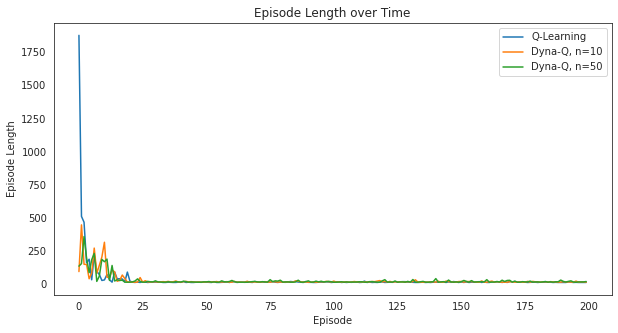

In [10]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(smooth(x, stats_q.episode_lengths), label="Q-Learning")
plt.plot(smooth(x, stats_dq.episode_lengths), label="Dyna-Q, n=10")
plt.plot(smooth(x, stats_dq2.episode_lengths), label="Dyna-Q, n=50")

plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.legend(loc="upper right")
plt.show()
